## Lab 7: Heart Attack

In [11]:
import pandas as pd
ha = pd.read_csv("C:/Users/spink/OneDrive/Desktop/Machine Learning/Data/heart_attack.csv")

In [12]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [13]:
ha.isna().sum()

age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

In [14]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


In [15]:
ha.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


## Part One: Fitting Models

Q1: KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = ha.drop('output', axis=1)
y = ha['output']

knn_pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

k_nums = {"kneighborsclassifier__n_neighbors": [3, 5, 7, 9, 11, 13, 15]}

gscv_knn = GridSearchCV(knn_pipeline,k_nums, cv=10,scoring="roc_auc")

gscv_knn.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11,
                                                               13, 15]},
             scoring='roc_auc')

In [17]:
gscv_knn.best_params_

{'kneighborsclassifier__n_neighbors': 15}

In [18]:
gscv_knn.best_score_

np.float64(0.8289224664224664)

In [19]:
knn_pipeline_15 = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=15)
)

knn_pipeline_15.fit(X, y)

knn_pipeline_15 = cross_val_score(knn_pipeline_15, X, y, cv=5, scoring="accuracy")
np.mean(knn_pipeline_15)

np.float64(0.7581818181818182)

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

knn_best = gscv_knn.best_estimator_

y_pred_knn = cross_val_predict(knn_best, X, y, cv=10)

cm_knn = confusion_matrix(y, y_pred_knn)
cm_knn

array([[ 86,  41],
       [ 27, 119]])

The best K vlaue was 15. I listed out a range of K values that balence overfitting at small values and underfitting at larger ones and then tuned using gridsearch to cross validate each value. The corosponding ROC AUC was 0.82. Out of everything we had 86 true nergatives as opposed to 27 false negatives nad 119 true prositve as opposed to 41 false positives. How good or bad that is depends on the requirments of the person asking.

Q2: Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

log_pipline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

log_nums = {"logisticregression__C": [0.01,0.1,1,10,100]}

gscv_log = GridSearchCV(log_pipline,log_nums, cv=10,scoring="roc_auc")

gscv_log.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

In [22]:
gscv_log.best_params_

{'logisticregression__C': 0.01}

In [23]:
gscv_log.best_score_

np.float64(0.8532600732600732)

In [24]:
log_best = gscv_log.best_estimator_

y_pred_log = cross_val_predict(log_best, X, y, cv=10)

cm_log = confusion_matrix(y, y_pred_log)
cm_log


array([[ 84,  43],
       [ 19, 127]])

In [25]:
log_reg = log_best.named_steps["logisticregression"]
coef = log_reg.coef_[0]
coeff_names = X.columns

log_coef_df = pd.DataFrame({
    "feature": coeff_names,
    "coef": coef
})

log_coef_df


,feature,coef
0,age,-0.136729
1,sex,-0.252337
2,cp,0.302322
3,trtbps,-0.097634
4,chol,-0.054690
5,restecg,0.086628
6,thalach,0.280505


The best penalty paremter is 0.01. I listed out a range of log paremter values that balence overfitting at small values and underfitting at larger ones and then ran gridsearch with the pipline and parameters to do the tuning. The corrospomding ROC AUC was 0.85. Out of everything we had 84 true nergatives as opposed to 19 false negatives had 127 true prositve as opposed to 43 false positives. How good or bad that is depends on the requirments of the person asking. The coefficant that has the most impact on liklehood of a heart attack during exereise appreas to be chest pain followed by maximum heart rate (thalach).

Q3: Decision Tree

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)

# min_impunity_decresese 


param_grid_tree = {
    "max_depth": [2, 3, 4, 5, 6, 8, None],
    "min_samples_leaf": [1, 5, 10]
}

gscv_tree = GridSearchCV(tree, param_grid_tree, cv=10, scoring="roc_auc")

gscv_tree.fit(X, y)

gscv_tree.best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

In [27]:
gscv_tree.best_score_

np.float64(0.8238858363858365)

In [50]:
dt_best = gscv_tree.best_estimator_

y_pred_dt = cross_val_predict(dt_best, X, y, cv=10)

cm_tree = confusion_matrix(y, y_pred_dt)
cm_tree

array([[ 99,  28],
       [ 35, 111]])

In [51]:
dt_best = gscv_tree.best_estimator_

tree_coef_df = pd.DataFrame({
    "feature": X.columns,
    "importance": dt_best.feature_importances_
})

tree_coef_df

,feature,importance
0,age,0.156569
1,sex,0.102721
2,cp,0.584983
3,trtbps,0.038793
4,chol,0.000000
5,restecg,0.000000
6,thalach,0.116935


The best Decision Tree metrics are 'max_depth': 3, 'min_samples_leaf': , which means the data is only divided based on three condition and no less than ten vexplaotry varibels can be included on one side of each descion. I listed out a range of paremter values and tunned with gridsearch. The corrospomding ROC AUC for the best metrics was 0.83. Out of all predictions we had 84 true negatives as opposed to 19 false negatives had 127 true positve as opposed to 43 false positives. How good or bad that is depends on the requirments of the person asking. The coefficant that has the most impact on liklehood of a heart attack during exereise appreas to be chest pain followed by age.

Q4: Interpretation

Chest pain was by far the most important both times, which makes sense because it is the most direct explanatory variable.
If your chest is in unusual pain, the odds that you're having a heart attack are pretty high, as opposed to, say, being a bit overweight. Resting heart rate and age were the second most important predictors in the Logistic Regression and the Decision Tree, respectively.

Q5: ROC Curve

Knn

In [30]:
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

#googled how to plot ROC and found roc_curve package

y_prob_knn_best = cross_val_predict(knn_best,X, y, cv=10, method="predict_proba")

fpr_knn, tpr_knn, _ = roc_curve(y, y_prob_knn_best[:, 1])

df_knn_roc = pd.DataFrame({
    "fpr": fpr_knn,
    "tpr": tpr_knn
})




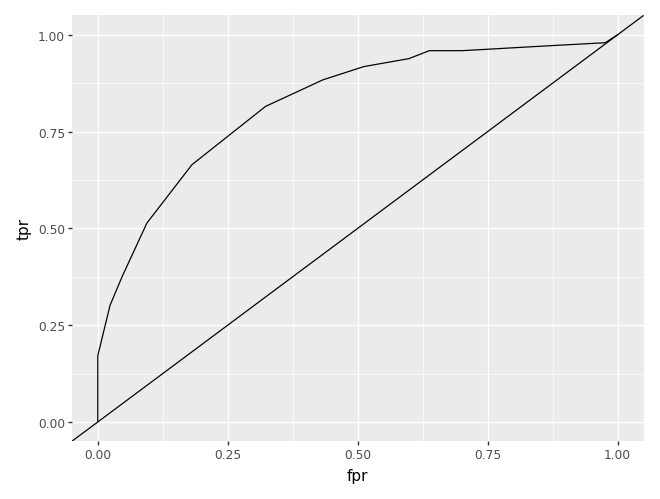

In [31]:
from plotnine import ggplot, aes, geom_line, geom_abline

p_knn_roc_plot = (
    ggplot(df_knn_roc, aes(x="fpr", y="tpr"))
    + geom_line()
    + geom_abline()
)

p_knn_roc_plot

Logical Regression

In [32]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

y_prob_log_best = cross_val_predict(log_best,X,y,cv=10,method="predict_proba")

fpr_log, tpr_log, _ = roc_curve(y, y_prob_log_best[:, 1])

df_log_roc = pd.DataFrame({
    "fpr": fpr_log,
    "tpr": tpr_log
})

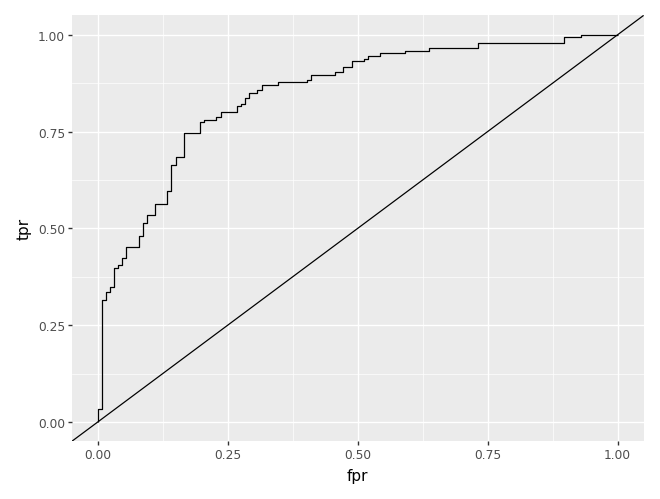

In [33]:
from plotnine import ggplot, aes, geom_line, geom_abline

p_log_roc_plot = (
    ggplot(df_log_roc, aes(x="fpr", y="tpr"))
    + geom_line()
    + geom_abline()
)

p_log_roc_plot

Decsion Tree

In [34]:
y_prob_dt_best = cross_val_predict(dt_best, X, y,cv=10, method="predict_proba")

fpr_dt, tpr_dt, _ = roc_curve(y, y_prob_dt_best[:, 1])

In [35]:
df_dt_roc = pd.DataFrame({
    "fpr": fpr_dt,
    "tpr": tpr_dt
})

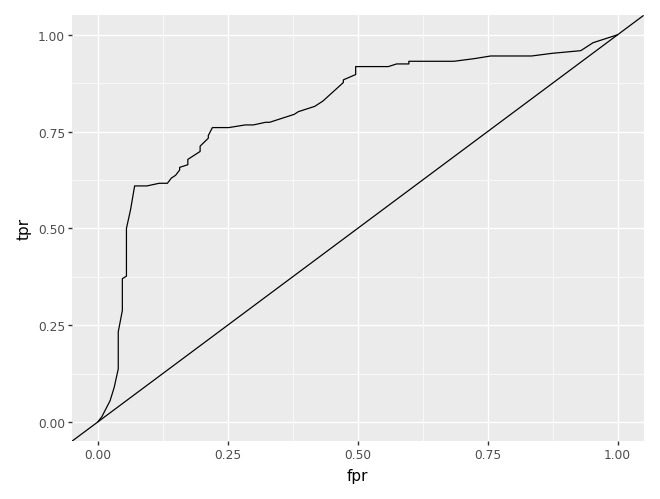

In [36]:
p_tree_roc_plot = (
    ggplot(df_dt_roc, aes(x="fpr", y="tpr"))
    + geom_line()
    + geom_abline()
)

p_tree_roc_plot


## Part Two: Metrics

In [37]:
is_positive = (y == 1)

sens_knn  = cross_val_score(knn_best, X, is_positive, cv=10, scoring="recall").mean()

sens_log  = cross_val_score(log_best,X, is_positive, cv=10, scoring="recall").mean()

sens_dt = cross_val_score(dt_best, X, is_positive, cv=10, scoring="recall").mean()

In [38]:
sens_knn

np.float64(0.8147619047619047)

In [39]:
sens_log

np.float64(0.8695238095238096)

In [40]:
sens_dt

np.float64(0.76)

In [41]:
prec_knn  = cross_val_score(knn_best,  X, is_positive, cv=10, scoring="precision").mean()

prec_log  = cross_val_score(log_best,  X, is_positive, cv=10, scoring="precision").mean()

prec_dt = cross_val_score(dt_best, X, is_positive, cv=10, scoring="precision").mean()

In [42]:
prec_knn

np.float64(0.7446428571428572)

In [43]:
prec_log

np.float64(0.7522940647244052)

In [44]:
prec_dt

np.float64(0.7949490950226245)

In [45]:
is_negative = (y == 0)

spec_knn  = cross_val_score(knn_best,  X, is_negative, cv=10, scoring="recall").mean()

spec_log  = cross_val_score(log_best,  X, is_negative, cv=10, scoring="recall").mean()

spec_dt = cross_val_score(dt_best, X, is_negative, cv=10, scoring="recall").mean()

In [46]:
spec_knn

np.float64(0.6775641025641026)

In [47]:
spec_log

np.float64(0.6628205128205129)

In [48]:
spec_dt

np.float64(0.7493589743589744)

## Part Three: Discussion

Q1

The metrics would be accuracy, Precision, recall (spec), and ROC AUC. Accuracy measures overall correctness, Precision focuses on avoiding false positives, Recall measures false negatives so we don t miss cases, and ROC AUC shows how well the model separates the classes. Logitic Regession the best recal so that woudl be the specific metric I would use. I would expect a score simialt to what I got in part 2. 

Q2

The metrics I would use would be Logsitic Regresssion is the best model for the hostpitals needs. I would still recommend Logitic Reggresion becaue it had the best recall score, which means the leaest minimizing false negatives. Some coefficant I might also pay attention too would be cp and thlach (maximum heart rate), which were the two most impactful explanatory varaibles for Logistic Regression.I would expect a score simialt to what I got in part 2. 



Q3

ROC AUC would be a good metric to measure accuracy. I would go would use a descion tree becuase it would be alot easier to explain to non technical hospital employees, while still being able to produce metrics unlike Knn. I would expect a score simialt to what I got in part 2. 

Q4

I would use ROC AUC to compare Knn and Logistic Regression, and pick the one with the better fit curve which seems to be Knn. I would expect a score simialt to what I got in part 2. 

## Part Four: Validation

In [87]:
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")


In [88]:
ha_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


Knn

In [89]:
X_val = ha_validation.drop("output", axis=1)
y_val = ha_validation["output"]

In [90]:
y_pred_knn = knn_best.predict(X_val)
y_prob_knn = knn_best.predict_proba(X_val)[:, 1]

In [91]:
cm_knn = confusion_matrix(y_val, y_pred_knn)
cm_knn

array([[10,  1],
       [ 5, 14]])

In [92]:
roc_auc_knn = roc_auc_score(y_val, y_prob_knn)
roc_auc_knn

np.float64(0.9401913875598086)

In [93]:
precision_knn = precision_score(y_val, y_pred_knn)
precision_knn

0.9333333333333333

In [94]:
recall_knn = recall_score(y_val, y_pred_knn)
recall_knn

0.7368421052631579

Logistic Regression

In [95]:
y_pred_log = log_best.predict(X_val)
y_prob_log = log_best.predict_proba(X_val)[:, 1]

In [96]:
cm_log = confusion_matrix(y_val, y_pred_log)
cm_log

array([[10,  1],
       [ 4, 15]])

In [97]:
roc_auc_log = roc_auc_score(y_val, y_prob_log)
roc_auc_log

np.float64(0.937799043062201)

In [98]:
precision_log = precision_score(y_val, y_pred_log)
precision_log

0.9375

In [99]:
recall_log = recall_score(y_val, y_pred_log)
recall_log

0.7894736842105263

Decision Tree Model

In [100]:
y_pred_dt = dt_best.predict(X_val)
y_prob_dt = dt_best.predict_proba(X_val)[:, 1]

In [101]:
cm_dt = confusion_matrix(y_val, y_pred_dt)
cm_dt

array([[ 9,  2],
       [ 7, 12]])

In [102]:
roc_auc_dt = roc_auc_score(y_val, y_prob_dt)
roc_auc_dt

np.float64(0.8325358851674641)

In [103]:
precision_dt = precision_score(y_val, y_pred_dt)
precision_dt

0.8571428571428571

In [104]:
recall_dt = recall_score(y_val, y_pred_dt)
recall_dt

0.631578947368421

Comparison (old first then new)

In [105]:
prec_knn, sens_knn, prec_log, sens_log, prec_dt, sens_dt

(np.float64(0.7446428571428572),
 np.float64(0.8147619047619047),
 np.float64(0.7522940647244052),
 np.float64(0.8695238095238096),
 np.float64(0.7949490950226245),
 np.float64(0.76))

In [106]:
precision_knn, recall_knn, precision_log, recall_log, precision_dt, recall_dt

(0.9333333333333333,
 0.7368421052631579,
 0.9375,
 0.7894736842105263,
 0.8571428571428571,
 0.631578947368421)

In general the model I made either did better on the new data or only slighlty worse. Decide ona pipline, for the tree both are lower so that bad, if through knn what k. 


## Part 5: Cohen's Kappa

In [107]:
from sklearn.metrics import cohen_kappa_score

kappa_knn = cohen_kappa_score(y_val, y_pred_knn)
kappa_knn

np.float64(0.6)

In [108]:
kappa_log = cohen_kappa_score(y_val, y_pred_log)
kappa_log

np.float64(0.660633484162896)

In [109]:
kappa_dt = cohen_kappa_score(y_val, y_pred_dt)
kappa_dt

np.float64(0.4104803493449781)

We would use Cohnes kappa if there were signs that the modle was finding it too easy to preict data, possibly cuased by data being imblenced, or overfit by coincadence for our model.Logisitic Regression has the highest, however, the metrics used in early part were also pointed to logistic regression being the best model. So, our conclusiosn dont meansifuly change from using Cohnes Kappa. So prorbaly the data is well balence and not too easy and or overfitted by nature for the model. 